<div align="center">
<Br> 🔐 Projet Mastercamp 202</Br> <Br>Surveillance & Analyse Automatisée des Vulnérabilités ANSSI (CVE)</Br>E)

**Participants :**  
- Abouleila Selim  
- Sozer Begumu  
- Nguedia Duval  
- Sami Samiali  

</div>


</div>


# Étape 1 : Récupération des liens des bulletins ANSSI

## Objectif
Collecter automatiquement les URLs des bulletins d’alerte et d’avis publiés par l’ANSSI pour alimenter la veille de vulnérabilités)
html = response.text


In [19]:
import feedparser

url = "https://www.cert.ssi.gouv.fr/avis/feed/"
rss_feed = feedparser.parse(url)

for entry in rss_feed.entries:
    print(entry.title, entry.link, entry.published, entry.description)

Multiples vulnérabilités dans Mattermost Server (13 mai 2025) https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-0392/ Tue, 13 May 2025 00:00:00 +0000 De multiples vulnérabilités ont été découvertes dans Mattermost Server. Elles permettent à un attaquant de provoquer une atteinte à la confidentialité des données et un contournement de la politique de sécurité.
Multiples vulnérabilités dans les produits SAP (13 mai 2025) https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-0396/ Tue, 13 May 2025 00:00:00 +0000 De multiples vulnérabilités ont été découvertes dans les produits SAP. Certaines d'entre elles permettent à un attaquant de provoquer une exécution de code arbitraire à distance, une atteinte à la confidentialité des données et une injection de code indirecte à distance (XSS).
Vulnérabilité dans Roundcube (02 juin 2025) https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-0468/ Mon, 02 Jun 2025 00:00:00 +0000 Une vulnérabilité a été découverte dans Roundcube Roundcube Webmail. Elle perme

In [21]:
import feedparser
url2 = "https://www.cert.ssi.gouv.fr/alerte/feed"
rss_alerte = feedparser.parse(url2)

for entry in rss_alerte.entries:
    print("Title:", entry.title)
    print("Link:", entry.link)
    print("Published:", entry.published)
    print("Description:", entry.description)
    print("-" * 20) # Print a separator line

Title: Multiples vulnérabilités dans Microsoft Windows (16 septembre 2022)
Link: https://www.cert.ssi.gouv.fr/alerte/CERTFR-2022-ALE-007/
Published: Fri, 16 Sep 2022 00:00:00 +0000
Description: \[MàJ du 31 octobre 2022\] Une preuve de concept est publiquement disponible. \[Publication initiale\] Dans le cadre de son *Patch Tuesday*, en date du 13 septembre 2022, Microsoft a indiqué l'existence de multiples vulnérabilités au sein de plusieurs versions de Windows. Trois d'entre elles...
--------------------
Title: [MaJ] Multiples vulnérabilités dans Microsoft Exchange (30 septembre 2022)
Link: https://www.cert.ssi.gouv.fr/alerte/CERTFR-2022-ALE-008/
Published: Fri, 30 Sep 2022 00:00:00 +0000
Description: \[Mise à jour du 09 novembre 2022\] L'éditeur a publié un correctif (cf. section solution). En date du 29 septembre 2022, Microsoft a indiqué l'existence de deux vulnérabilités, de type zéro-jour, au sein de Windows Exchange 2013, 2016 et 2019. Ces vulnérabilités sont les suivantes : -..

# Étape 2 : Extraction des CVE

## Objectif
Extraire automatiquement les identifiants CVE (« Common Vulnerabilities and Exposures ») à partir du JSON de chaque bulletin ANSSI.

In [89]:
# -----------------------------------------------------------
# 1) Imports + where the raw files live
# -----------------------------------------------------------
from pathlib import Path
import json, re, html
import pandas as pd
from json import JSONDecodeError

ALERTE_DIR = Path(r"C:\Users\alpha\Documents\GitHUB_Projects\Atelier_Data_Porject\Atelier_Data_Project\data_pour_TD_final\alertes")
AVIS_DIR   = Path(r"C:\Users\alpha\Documents\GitHUB_Projects\Atelier_Data_Porject\Atelier_Data_Project\data_pour_TD_final\Avis")

# -----------------------------------------------------------
# 2) Helpers
# -----------------------------------------------------------
def strip_md(text: str | None) -> str:
    """Drop HTML/Markdown – keep plain text."""
    if not text:
        return ""
    text = re.sub(r"<[^>]+>", "", text)        # HTML tags
    text = re.sub(r"[*_`#>-]", "", text)       # basic MD chars
    return html.unescape(text).strip()


def read_json(path: Path) -> dict | None:
    """Try UTF-8 first, then cp1252; return None if not JSON."""
    for enc in ("utf-8", "cp1252"):
        try:
            return json.loads(path.read_text(encoding=enc))
        except (UnicodeDecodeError, JSONDecodeError):
            continue
    return None


def record_from_obj(obj: dict, kind: str) -> dict:
    """Flatten one CERT-FR object into a flat dict ready for DataFrame."""
    return {
        "reference": obj.get("reference"),
        "title":     obj.get("title"),
        "closed_at": obj.get("closed_at") if kind == "alerte" else "",
        "cves":      "; ".join(c["name"] for c in obj.get("cves", [])) or "Aucune",
        "risks":     "; ".join(r["description"] for r in obj.get("risks", [])) or "Non précisé",
        "summary":   strip_md(obj.get("summary"))[:1500],   # trim long blobs
        "first_revision": (obj.get("revisions") or [{}])[0].get("revision_date", ""),
        "affected_systems": " | ".join(
            f'{s.get("product", {}).get("vendor", {}).get("name","?")} '
            f'{s.get("product", {}).get("name","?")} – {s.get("description","")}'
            for s in obj.get("affected_systems", [])
        ),
    }

# -----------------------------------------------------------
# 3) Walk the folders, parse everything
# -----------------------------------------------------------
def build_df(folder: Path, kind: str) -> pd.DataFrame:
    rows, bad = [], []
    for f in folder.rglob("*"):                 # recurse (works with nested folders)
        if not f.is_file():
            continue
        obj = read_json(f)
        if obj is None:
            bad.append(f.name)
            continue
        rows.append(record_from_obj(obj, kind))
    if bad:
        print(f"⚠️  {len(bad)} files in '{folder.name}' skipped (non-JSON or unreadable)")
    return pd.DataFrame(rows)

alerte_df = build_df(ALERTE_DIR, "alerte")
avis_df   = build_df(AVIS_DIR,   "avis")


# -----------------------------------------------------------
# 4) Write the spreadsheets & preview
# -----------------------------------------------------------
alerte_df.to_csv("alertes.csv", index=False, encoding="utf-8")
avis_df.to_csv("avis.csv",     index=False, encoding="utf-8")

print(f"✅  {len(alerte_df):>4} alertes → alertes.csv")
print(f"✅  {len(avis_df):>4} avis    → avis.csv")

display(alerte_df.head())
display(avis_df.head())



✅    72 alertes → alertes.csv
✅  2673 avis    → avis.csv


,reference,title,closed_at,cves,risks,summary,first_revision,affected_systems
0,CERTFR-2021-ALE-001,|MàJ] Vulnérabilité dans SonicWall SMA100,2021-05-12,CVE-2021-20016; CVE-2014-6271,Exécution de code arbitraire à distance,\[Mise à jour du 30 avril 2021\]\n\nLe 29 avri...,2021-02-02T01:00:00.000000,"Sonicwall Secure Mobile Access – SMA 200, SMA ..."
1,CERTFR-2021-ALE-002,[MàJ] Vulnérabilité dans Google Chrome et Micr...,2021-03-11,CVE-2021-21148,Non spécifié par l'éditeur,\[Mise à jour du 08 février 2021\]\n\nLe navig...,2021-02-05T01:00:00.000000,Microsoft Edge – Microsoft Edge (Chromium-base...
2,CERTFR-2021-ALE-003,[MàJ] Vulnérabilité dans VMware vCenter Server,2021-05-12,CVE-2021-21972,Exécution de code arbitraire à distance,\[version du 26 février 2021\]\n\nLe CERTFR a ...,2021-02-25T01:00:00.000000,VMware vCenter Server – Cloud Foundation (vCen...
3,CERTFR-2021-ALE-004,[MàJ] Multiples vulnérabilités dans Microsoft ...,2021-07-16,CVE-2021-26858; CVE-2021-27078; CVE-2021-26857...,Exécution de code arbitraire à distance,\[version du 16 mars 2021\]\n\nle 15 mars 2021...,2021-03-03T01:00:00.000000,
4,CERTFR-2021-ALE-005,Multiples vulnérabilités dans Microsoft DNS se...,2021-05-12,CVE-2021-26893; CVE-2021-26897; CVE-2021-26894...,Exécution de code arbitraire à distance,Contexte\n\nSept vulnérabilités concernant le ...,2021-03-12T01:00:00.000000,


,reference,title,closed_at,cves,risks,summary,first_revision,affected_systems
0,CERTFR-2023-AVI-0001,Vulnérabilité dans Apache Tomcat,,CVE-2022-45143,Non spécifié par l'éditeur,Une vulnérabilité a été découverte dans Apache...,2023-01-04T01:00:00.000000,Apache Tomcat – Apache Tomcat versions 9.x ant...
1,CERTFR-2023-AVI-0002,Multiples vulnérabilités dans les produits For...,,CVE-2022-45857; CVE-2022-35845; CVE-2022-39947...,Injection de code indirecte à distance (XSS); ...,De multiples vulnérabilités ont été corrigées ...,2023-01-04T01:00:00.000000,Fortinet FortiADC – FortiADC versions 7.x anté...
2,CERTFR-2023-AVI-0003,Multiples vulnérabilités dans les produits And...,,CVE-2022-22088; CVE-2022-42720; CVE-2022-44436...,Déni de service à distance; Exécution de code ...,De multiples vulnérabilités ont été découverte...,2023-01-04T01:00:00.000000,"Google Android – Android 10, 11, 12, 12L, 13 s..."
3,CERTFR-2023-AVI-0004,Multiples vulnérabilités dans IBM Sterling Glo...,,CVE-2021-44521; CVE-2020-10663,Exécution de code arbitraire à distance; Conto...,De multiples vulnérabilités ont été découverte...,2023-01-04T01:00:00.000000,IBM Sterling – IBM Sterling Global Mailbox ver...
4,CERTFR-2023-AVI-0005,Vulnérabilité dans Synology VPN Plus Server,,CVE-2022-43931,Exécution de code arbitraire à distance,Une vulnérabilité a été découverte dans Synolo...,2023-01-04T01:00:00.000000,Synology SRM – VPN Plus Server pour SRM 1.3 ve...


In [93]:
# -----------------------------------------------------------
# 5) Rassembler tous les identifiants CVE en une seule liste
# -----------------------------------------------------------
import re

# concatène les deux colonnes cves, les nettoie et garde le bon format
cve_ids = (
    pd.concat([alerte_df["cves"], avis_df["cves"]])  # une seule série
      .dropna()                                     # enlève les NaN
      .str.split(";")                               # sépare "CVE1; CVE2"
      .explode()                                    # une ligne par CVE
      .str.strip()                                  # espaces
      .loc[lambda s: s.str.match(r"^CVE-\d{4}-\d{4,}$")]  # filtre vrai format
      .unique()                                     # dé-duplication
      .tolist()                                     # -> liste Python
)

print(f"📌 {len(cve_ids)} identifiants CVE collectés")

# (optionnel) écrire la liste dans un fichier texte pour vérification
with open("cve_ids.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(cve_ids))
print("📝  Liste enregistrée dans cve_ids.txt")


📌 22309 identifiants CVE collectés
📝  Liste enregistrée dans cve_ids.txt


# Étape 3 : Enrichissement des CVE

## Objectif  
Pour chaque identifiant CVE extrait, récupérer automatiquement ses métadonnées (description, scores CVSS, date de publication, sources externes, EPSS…) afin de pouvoir prioriser et consolider la veille.


In [101]:
# -----------------------------------------------------------
# 6) Interroger les API MITRE CVE AWG + EPSS pour chaque CVE
# -----------------------------------------------------------
import requests, json, time
import pandas as pd
from pathlib import Path

# 1) Lire la liste des CVE collectés à l’étape 5
with open("cve_ids.txt", encoding="utf-8") as f:
    cve_list = [ln.strip() for ln in f if ln.strip()]


cve_list = cve_list[:500]          # ← limite aux 1 000 premiers identifiants

print(f"🔍  Interrogation de {len(cve_list)} identifiants CVE")

# 2) Préparer une structure pour stocker tous les résultats
records = []

# 3) Boucle principale — le code interne est VOTRE exemple inchangé
for cve_id in cve_list:
    try:
        # ================= MITRE CVE AWG =================
        url = f"https://cveawg.mitre.org/api/cve/{cve_id}"
        response = requests.get(url, timeout=15)
        data = response.json()           # <-- peut lever ValueError si pas du JSON

        # Extraire la description
        description = data["containers"]["cna"]["descriptions"][0]["value"]

        # Extraire le score CVSS (prise en compte de toutes les variantes)
        cvss_score = ""
        try:
            cvss_score = data["containers"]["cna"]["metrics"][0]["cvssV3_1"]["baseScore"]
        except KeyError:
            try:
                cvss_score = data["containers"]["cna"]["metrics"][0]["cvssV3_0"]["baseScore"]
            except KeyError:
                pass                        # le champ n’existe pas → reste vide

        # Extraire le CWE
        cwe       = "Non disponible"
        cwe_desc  = "Non disponible"
        problemtype = data["containers"]["cna"].get("problemTypes", [])
        if problemtype and problemtype[0].get("descriptions"):
            cwe       = problemtype[0]["descriptions"][0].get("cweId", "Non disponible")
            cwe_desc  = problemtype[0]["descriptions"][0].get("description", "Non disponible")

        # Extraire les produits affectés
        affected_str = ""
        affected = data["containers"]["cna"].get("affected", [])
        if affected:
            lines = []
            for product in affected:
                vendor        = product.get("vendor", "Inconnu")
                product_name  = product.get("product", "Inconnu")
                versions = [
                    v["version"]
                    for v in product.get("versions", [])
                    if v.get("status") == "affected"
                ]
                lines.append(f"{vendor} | {product_name} | {', '.join(versions)}")
            affected_str = " || ".join(lines)

        # ================ EPSS ============================
        epss_score = ""
        try:
            url_epss = f"https://api.first.org/data/v1/epss?cve={cve_id}"
            epss_resp = requests.get(url_epss, timeout=10)
            epss_json = epss_resp.json()
            epss_data = epss_json.get("data", [])
            if epss_data:
                epss_score = epss_data[0]["epss"]
        except Exception:
            pass  # on ignore les échecs EPSS

        # Affichage (conserve exactement vos prints)
        print(f"\nCVE : {cve_id}")
        print(f"Description : {description}")
        print(f"Score CVSS : {cvss_score}")
        print(f"Type CWE : {cwe}")
        print(f"CWE Description : {cwe_desc}")
        print(f"Score EPSS : {epss_score}")
        if affected_str:
            print(f"Produits affectés : {affected_str}")

        # Mémoriser dans la table finale
        records.append(
            {
                "cve":            cve_id,
                "description":    description,
                "cvss_score":     cvss_score,
                "cwe":            cwe,
                "cwe_description": cwe_desc,
                "epss_score":     epss_score,
                "affected":       affected_str,
            }
        )

        time.sleep(0.001)  # petite pause pour ne pas surcharger les API

    except Exception as e:
        print(f"\n⚠️  Problème avec {cve_id} → {e}")

# 4) Exporter la récolte dans un CSV
out_df = pd.DataFrame(records)
out_df.to_csv("cve_enrichissement_api.csv", index=False, encoding="utf-8")
print(f"\n  Fichier 'cve_enrichissement_api.csv' écrit ({len(out_df)} lignes)")


🔍  Interrogation de 1000 identifiants CVE

CVE : CVE-2021-20016
Description : A SQL-Injection vulnerability in the SonicWall SSLVPN SMA100 product allows a remote unauthenticated attacker to perform SQL query to access username password and other session related information. This vulnerability impacts SMA100 build version 10.x.
Score CVSS : 
Type CWE : CWE-89
CWE Description : CWE-89: Improper Neutralization of Special Elements used in an SQL Command ('SQL Injection')
Score EPSS : 0.804450000
Produits affectés : SonicWall | SonicWall SMA100 | SMA100 build version 10.x

CVE : CVE-2014-6271
Description : GNU Bash through 4.3 processes trailing strings after function definitions in the values of environment variables, which allows remote attackers to execute arbitrary code via a crafted environment, as demonstrated by vectors involving the ForceCommand feature in OpenSSH sshd, the mod_cgi and mod_cgid modules in the Apache HTTP Server, scripts executed by unspecified DHCP clients, and oth

# Étape 4 : Consolidation des Données

## Objectif  
Assembler en un seul tableau (DataFrame Pandas) l’ensemble des métadonnées ANSSI et CVE enrichies, pour pouvoir filtrer, trier et exporter facilement.

## Structure du DataFrame  
| Colonne                 | Description                                                    |
|-------------------------|----------------------------------------------------------------|
| **ID ANSSI**            | Identifiant du bulletin (ex. `CERTFR-2024-ALE-001`)            |
| **Titre ANSSI**         | Titre de l’avis ou de l’alerte                                 |
| **Type**                | `'Alerte'` ou `'Avis'`                                         |
| **Date**                | Date de publication (YYYY-MM-JJ)                               |
| **Lien**                | URL du bulletin ANSSI                                          |
| **CVE**                 | Identifiant de la vulnérabilité                                |
| **CVSS**                | Score CVSS (0–10)                                              |
| **Base Severity**       | Gravité associée (Faible, Moyenne, Élevée, Critique)          |
| **CWE**                 | Code CWE (ex. `CWE-79`)                                        |
| **EPSS**                | Score EPSS (0–1)                                               |
| **Description**         | Description détaillée issue des API                            |
| **Éditeur**             | Vendor du produit affecté                                      |
| **Produit**             | Nom du produit                                                 |
| **Versions affectées**  | Chaîne de versions impactées (séparées par des virgules)       |

## Exemple de DataFrame  
| ID ANSSI             | Titre ANSSI                         | Type   | Date       | CVE              | CVSS | Base Severity | CWE    | EPSS  | Lien                                  | Description                                   | Éditeur | Produit | Versions affectées   |
|----------------------|--------------------------------------|--------|------------|------------------|------|---------------|--------|-------|---------------------------------------|-----------------------------------------------|---------|---------|----------------------|
| CERTFR-2024-ALE-001  | Multiples vulnérabilités dans Ivanti | Alerte | 2024-01-11 | CVE-2024-49126   | 9.0  | Critique      | CWE-287| 0.85  | https://…/CERTFR-2024-ALE-001/json/   | Authentication bypass…                        | Ivanti  | ICS     | 9.1R18, 22.6R2       |
| CERTFR-2024-ALE-001  | Multiples vulnérabilités dans Ivanti | Alerte | 2024-01-11 | CVE-2023-46805   | 8.2  | Élevée        | —      | 0.94  | https://…/CERTFR-2024-ALE-001/json/   | Authentication bypass…                        | Ivanti  | IPS     | 9.1R18, 22.6R1       |

In [4]:
import pandas as pd
from pathlib import Path

# -----------------------------------------------------------
# 1) Lecture du fichier CSV
# -----------------------------------------------------------
csv_path = Path("cve_enrichissement_api.csv")  # adaptez si besoin
if not csv_path.exists():
    raise FileNotFoundError(
        f"Le fichier {csv_path} est introuvable. "
        "Vérifiez son nom ou son emplacement."
    )

df_raw = pd.read_csv(csv_path, encoding="utf-8")

# -----------------------------------------------------------
# 2) Nettoyage & typage
# -----------------------------------------------------------
# Score CVSS et EPSS en flottants (parfois vides → erreurs silencieuses)
df_raw["cvss_score"] = pd.to_numeric(df_raw["cvss_score"], errors="coerce")
df_raw["epss_score"] = pd.to_numeric(df_raw["epss_score"], errors="coerce").round(4)

# -----------------------------------------------------------
# 3) Base Severity (selon CVSS v3.x)
# -----------------------------------------------------------
def cvss_to_severity(score: float | None) -> str:
    if pd.isna(score):
        return "Non défini"
    if score < 4.0:
        return "Faible"
    if score < 7.0:
        return "Moyenne"
    if score < 9.0:
        return "Élevée"
    return "Critique"

df_raw["base_severity"] = df_raw["cvss_score"].apply(cvss_to_severity)

# -----------------------------------------------------------
# 4) Décomposition de la colonne 'affected'
# -----------------------------------------------------------
# La chaîne est de la forme «vendor | product | 1.0, 1.1 || …»
def split_affected(row):
    if pd.isna(row):
        return pd.Series({"vendor": None, "product": None, "versions": None})
    # On ne garde que le premier triplet (si plusieurs produits séparés par ' || ')
    first = row.split(" || ")[0]
    parts = [p.strip() for p in first.split("|")]
    # Sécurité : on pad la liste
    parts += [None] * (3 - len(parts))
    vendor, product, versions = parts[:3]
    return pd.Series({"vendor": vendor, "product": product, "versions": versions})

affected_expanded = df_raw["affected"].apply(split_affected)
df = pd.concat([df_raw.drop(columns=["affected"]), affected_expanded], axis=1)

# -----------------------------------------------------------
# 5) Réorganisation des colonnes (ordre + renommage)
# -----------------------------------------------------------
df = df[
    [
        "cve",
        "cvss_score",
        "base_severity",
        "epss_score",
        "cwe",
        "cwe_description",
        "vendor",
        "product",
        "versions",
        "description",
    ]
].rename(
    columns={
        "cve": "CVE",
        "cvss_score": "CVSS Score",
        "base_severity": "Base Severity",
        "epss_score": "EPSS Score",
        "cwe": "CWE",
        "cwe_description": "CWE Description",
        "vendor": "Éditeur",
        "product": "Produit",
        "versions": "Versions affectées",
        "description": "Description",
    }
)

# -----------------------------------------------------------
# 6) Affichage et export
# -----------------------------------------------------------
print("\n↦ Aperçu du tableau (10 premières lignes) :")
display(df.head(10))     # fonctionne dans un notebook Jupyter

# Sauvegarde au besoin
df.to_csv("cve_table_finale.csv", index=False, encoding="utf-8")
df.to_excel("cve_table_finale.xlsx", index=False)
print("\n✅  Fichiers 'cve_table_finale.csv' et 'cve_table_finale.xlsx' créés.")



↦ Aperçu du tableau (10 premières lignes) :


,CVE,CVSS Score,Base Severity,EPSS Score,CWE,CWE Description,Éditeur,Produit,Versions affectées,Description
0,CVE-2021-20016,NaN,Non défini,0.8044,CWE-89,CWE-89: Improper Neutralization of Special Ele...,SonicWall,SonicWall SMA100,SMA100 build version 10.x,A SQL-Injection vulnerability in the SonicWall...
1,CVE-2014-6271,NaN,Non défini,0.9422,Non disponible,NaN,n/a,n/a,n/a,GNU Bash through 4.3 processes trailing string...
2,CVE-2021-21148,NaN,Non défini,0.5029,Non disponible,Heap buffer overflow,Google,Chrome,unspecified,Heap buffer overflow in V8 in Google Chrome pr...
3,CVE-2021-21972,NaN,Non défini,0.9374,Non disponible,Remote code execution vulnerability,n/a,VMware vCenter Server,"7.x before 7.0 U1c, 6.7 before 6.7 U3l, 6.5 be...",The vSphere Client (HTML5) contains a remote c...
4,CVE-2021-26858,7.8,Élevée,NaN,Non disponible,Remote Code Execution,Microsoft,Microsoft Exchange Server 2019,15.02.0,Microsoft Exchange Server Remote Code Executio...
5,CVE-2021-27078,9.1,Critique,0.4698,Non disponible,Remote Code Execution,Microsoft,Microsoft Exchange Server 2016 Cumulative Upda...,15.01.0,Microsoft Exchange Server Remote Code Executio...
6,CVE-2021-26857,7.8,Élevée,0.0699,Non disponible,Remote Code Execution,Microsoft,Microsoft Exchange Server 2016 Cumulative Upda...,15.01.0,Microsoft Exchange Server Remote Code Executio...
7,CVE-2021-26855,9.1,Critique,0.9437,Non disponible,Remote Code Execution,Microsoft,Microsoft Exchange Server 2016 Cumulative Upda...,15.01.0,Microsoft Exchange Server Remote Code Executio...
8,CVE-2021-27065,7.8,Élevée,0.9417,Non disponible,Remote Code Execution,Microsoft,Microsoft Exchange Server 2019,15.02.0,Microsoft Exchange Server Remote Code Executio...
9,CVE-2021-26412,9.1,Critique,0.3741,Non disponible,Remote Code Execution,Microsoft,Microsoft Exchange Server 2013 Cumulative Upda...,15.00.0,Microsoft Exchange Server Remote Code Executio...



✅  Fichiers 'cve_table_finale.csv' et 'cve_table_finale.xlsx' créés.


## Étape 5 — Interprétation & Visualisation

Avant toute génération d’alertes, il est crucial de **comprendre** les vulnérabilités recensées : quels produits sont les plus touchés ? quelles failles sont réellement critiques ? quelles menaces ont la probabilité d’exploitation la plus élevée ?  
Cette étape transforme le DataFrame enrichi en informations visuelles exploitables, afin de **prioriser les actions** et de **justifier vos choix de sécurité**. :contentReference[oaicite:0]{index=0}

### Objectifs

1. **Identifier rapidement** les vulnérabilités critiques (CVSS ≥ 9) et celles à forte probabilité d’exploitation (EPSS ≥ 0,7).  
2. **Repérer les produits / éditeurs** les plus exposés pour cibler les correctifs.  
3. Mettre en évidence les **catégories CWE** récurrentes pour orienter des mesures préventives.  
4. Fournir des **supports visuels** clairs pour la rédaction de rapports ou la présentation à un décideur non technique.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CVE                 994 non-null    object 
 1   CVSS Score          558 non-null    float64
 2   Base Severity       994 non-null    object 
 3   EPSS Score          976 non-null    float64
 4   CWE                 994 non-null    object 
 5   CWE Description     837 non-null    object 
 6   Éditeur             710 non-null    object 
 7   Produit             858 non-null    object 
 8   Versions affectées  827 non-null    object 
 9   Description         994 non-null    object 
dtypes: float64(2), object(8)
memory usage: 77.8+ KB


C:\Users\Begum\AppData\Local\Temp\ipykernel_18580\217139657.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Éditeur"].fillna("Non spécifié", inplace=True)
C:\Users\Begum\AppData\Local\Temp\ipykernel_18580\217139657.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

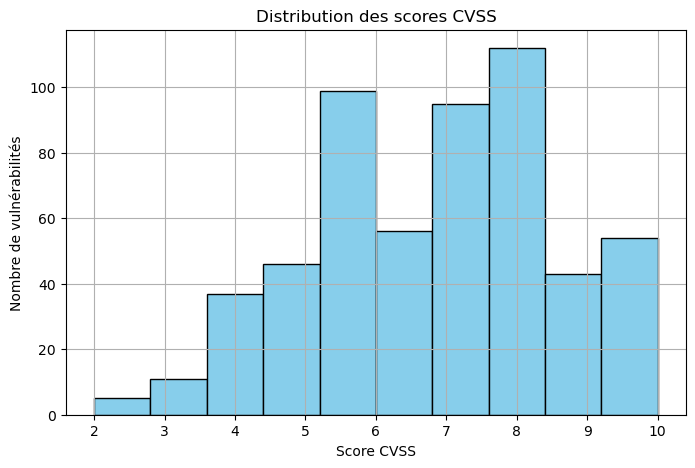

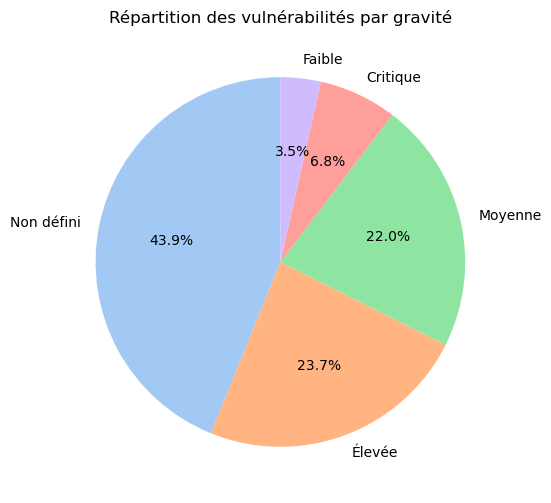

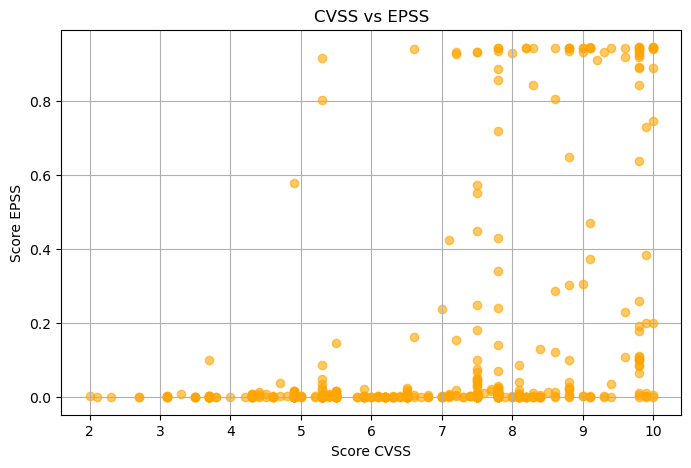

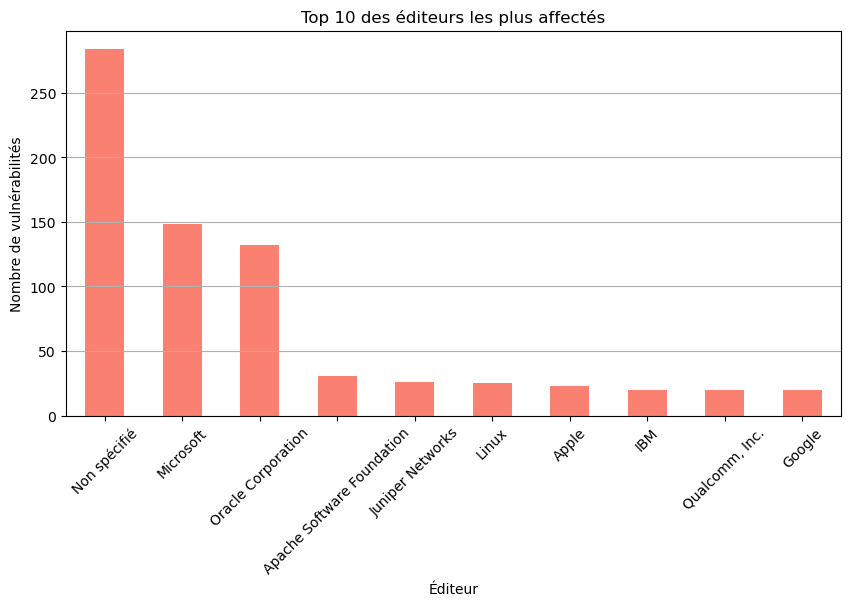

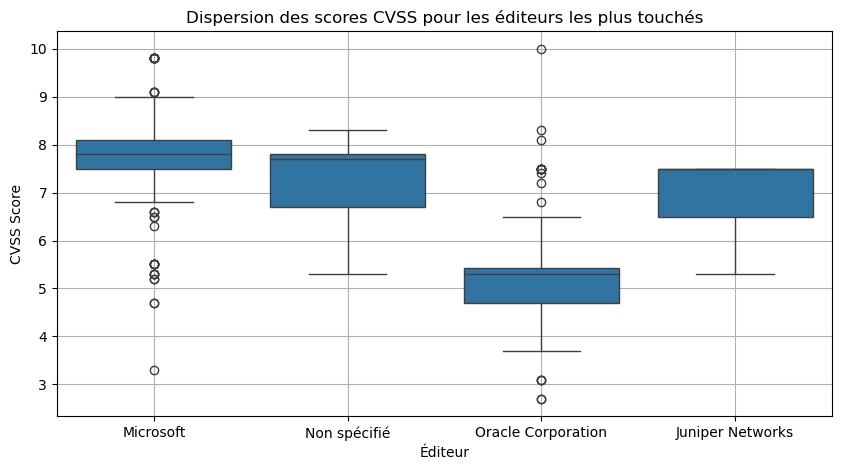

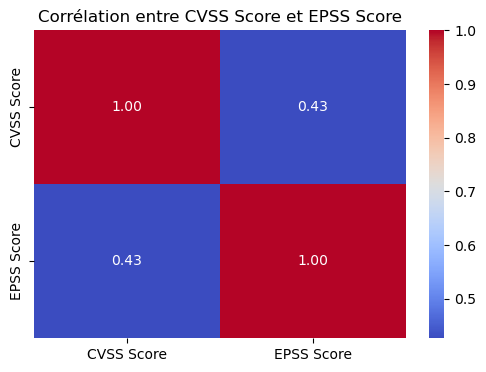

In [1]:
#etape 5
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
df = pd.read_csv("cve_table_finale.csv")

# Aperçu rapide
df.info()
df.head()

# Filtrer les lignes avec CVSS et EPSS valides
df_cvss = df[df["CVSS Score"].notnull()]
df_epss = df[df["EPSS Score"].notnull()]
df_cvss_epss = df_cvss[df_cvss["EPSS Score"].notnull()]

# Pour les colonnes texte : remplacer les NaN par "Non spécifié"
df["Éditeur"].fillna("Non spécifié", inplace=True)
df["Produit"].fillna("Non spécifié", inplace=True)
df["CWE Description"].fillna("Non spécifié", inplace=True)
df["Versions affectées"].fillna("Non spécifié", inplace=True)

plt.figure(figsize=(8, 5))
plt.hist(df_cvss["CVSS Score"], bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution des scores CVSS")
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
df["Base Severity"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title("Répartition des vulnérabilités par gravité")
plt.ylabel("")
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(df_cvss_epss["CVSS Score"], df_cvss_epss["EPSS Score"], alpha=0.6, color='orange')
plt.title("CVSS vs EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
df["Éditeur"].value_counts().head(10).plot(kind="bar", color="salmon")
plt.title("Top 10 des éditeurs les plus affectés")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

top_editeurs = df["Éditeur"].value_counts().head(5).index
df_top = df[df["Éditeur"].isin(top_editeurs) & df["CVSS Score"].notnull()]

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_top, x="Éditeur", y="CVSS Score")
plt.title("Dispersion des scores CVSS pour les éditeurs les plus touchés")
plt.grid(True)
plt.show()

import numpy as np

# Créer un DataFrame avec uniquement les colonnes numériques pertinentes
df_corr = df[["CVSS Score", "EPSS Score"]].dropna()

# Calcul de la corrélation
correlation_matrix = df_corr.corr()

# Affichage en heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélation entre CVSS Score et EPSS Score")
plt.show()